# 1. Download Dataset

In [10]:
!kaggle datasets download ilyakondrusevich/mushrooms

100%|███████████████████████████████████████▉| 359M/359M [00:32<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 359M/359M [00:32<00:00, 11.5MB/s]


# 2. Create Dataset Dict

In [1]:
#importing the libraries
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline


In [2]:
from torchvision.datasets import ImageFolder

/home/d_mamul/miniconda3/envs/course_work/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img = ImageFolder("mushrooms")
shroom = {}
for ind in img.imgs:
    value = [i for i in img.class_to_idx if img.class_to_idx[i]==ind[1]]
    value = value[0].split()[0]
    if value not in shroom:
        shroom[value] = list()
    shroom[value].append(ind[0])

shroom.pop('Fomitiporia'), shroom.pop('Guepinia'), shroom.pop('Volkartia');

In [5]:
# temp = list(shroom.keys())
# for key in temp:
#     if len(shroom[key]) < 100:
#         shroom.pop(key)

# SIZE OF SHROOM TO 91

In [6]:
# size = 0
# for i  in shroom.keys():
#     if len(shroom[i]):
#         print(i+': ' + str(len(shroom[i])))
#         size += 1
# print(size)

In [43]:
len(shroom.keys())

329

In [45]:
# plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [5]:
import random

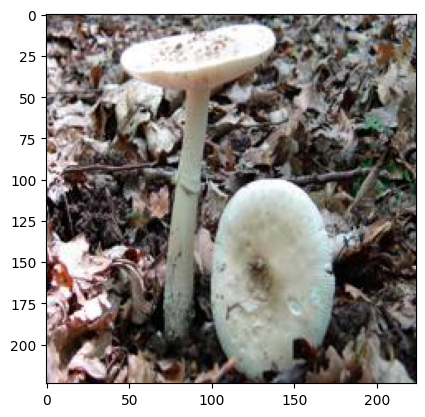

In [6]:
# images
temp = shroom['Amanita']
size = len(temp)
for _ in range(1):  
    j = random.randint(0,size)
    image = mpimg.imread(temp[j])
    plt.imshow(image)
    plt.show()

In [7]:
random.shuffle(shroom["Agaricus"])
shroom["Agaricus"];

In [8]:
import random
for key in shroom:
    random.shuffle(shroom[key])

In [9]:
# train dict
train_dict = {}
labels_dict = {}
y = -1
i = -1
for key in shroom:
    y += 1
    labels_dict[y] = key
    for elem in shroom[key][10:]:
        i += 1
        train_dict[i] = (elem, y)

In [14]:
# test dict
test_dict = {}
y = -1
i = -1
for key in shroom:
    y += 1
    for elem in shroom[key][:10]:
        i += 1
        test_dict[i] = (elem, y)

In [15]:
# DO NOT USE IT FOR NOW(DATASET FOR 1009 CLASSES)
# labels = {}
# for key in img.class_to_idx:
#     labels[img.class_to_idx[key]] = key
# labels;

# 3. Create CustomImageDataset

In [10]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, dataset, model="train"):
        self.dataset = dataset
        self.model = model
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        
        
        if self.model == "train":
            preprocessing = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                self.normalize,
            ])
            
        if self.model == "test":
            preprocessing = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                self.normalize,
            ])
            
        image = preprocessing(Image.open(self.dataset[idx][0]))
        label = self.dataset[idx][1] 
        path = self.dataset[idx][0]
        
        return image, label, path

In [5]:
train_dataset = CustomImageDataset(train_dict)
test_dataset = CustomImageDataset(test_dict, model="test")

NameError: name 'train_dict' is not defined

In [6]:
train_dataset[4][0].permute(1, 2, 0).shape

NameError: name 'train_dataset' is not defined

# 4. Create DataLoader

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

NameError: name 'train_dataset' is not defined

In [12]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

NameError: name 'train_dataloader' is not defined

# 5. Set Model 

In [48]:
from torchvision import models
from torch import nn
#model_ft = models.resnet50(pretrained=True)
model_ft = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model_ft._fc = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=329, bias=True)
        ) # num_ftrs = model_ft.fc.in_features 
#model_ft.fc = torch.nn.Linear(num_ftrs, 329) #91

In [13]:
import torch
import torch.nn as nn

class Model_ft(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Model_ft, self).__init__()
        
        # Define layers
        self._fc = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        )
        self.backbone = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1, classes=0)
        
    def forward(self, x):
        # Define forward pass
        
        x = self.backbone.features(x)
        embeddings = self.backbone.avgpool(x)
        embeddings = embeddings.view(embeddings.size(0), -1)
        out = self._fc(embeddings)
        
        return out, embeddings


In [106]:
model_ft = Model_ft(1280, 329)

In [92]:
# for param in model_ft.parameters():
#     param.requried_grad = False
# model_ft._fc.weight.requried_grad = True


In [107]:
for name, param in model_ft.named_parameters():
    param.requried_grad = True
    if "_fc.1" in name:
        param.requried_grad = True
        print(name)

_fc.1.weight
_fc.1.bias


# 6. Train Loop

## Plot utils

In [14]:
def save_plots(train_acc, test_acc, train_loss, test_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        test_acc, color='tab:red', linestyle='-', 
        label='test accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        test_loss, color='tab:red', linestyle='-', 
        label='test loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

## Train utils

In [26]:
import torch
from tqdm import tqdm
# Training function.
def train(model, trainloader, optimizer, scheduler, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels, _ = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs, embeddings = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        scheduler.step()
            
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

## Test utils


In [15]:
# Test function.
def test(model, testloader, criterion, device):
    model.eval()
    print('Test')
    test_running_loss = 0.0
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels, _ = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs, embeddings = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = test_running_loss / counter
    epoch_acc = 100. * (test_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

## Train

In [108]:
inf = (0.0001, 0.0006, 0.001)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import random
import copy


device = torch.device('cuda')
max_test_acc = 0
best_model = None

# Set seed.
# seed = 42
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True
# np.random.seed(seed)
# random.seed(seed)

In [30]:
epochs = 60
batch_size = 32
learning_rate = 0.0001

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # sampler=sampler shuffle=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'train_dataset' is not defined

In [113]:
plot_name = 'resnet_torchvision'

In [114]:
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

54,560,805 total parameters.
54,560,805 training parameters.


In [115]:
model_ft.to(device);

In [116]:
# Optimizer.
optimizer = optim.AdamW(model_ft.parameters(), lr=learning_rate, amsgrad="True", weight_decay=1e-3)#optim.Adam(model_ft.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=6e-4, cycle_momentum=False, mode="triangular2", step_size_up=6000)#3000
# Loss function.
criterion = nn.CrossEntropyLoss()

[INFO]: Epoch 1 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.00018833333333333338]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.82it/s]


Training loss: 3.114, training acc: 33.397
Test loss: 2.831, test acc: 33.313
--------------------------------------------------
[INFO]: Epoch 2 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.0002766666666666667]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.90it/s]


Training loss: 1.611, training acc: 58.265
Test loss: 2.170, test acc: 44.833
--------------------------------------------------
[INFO]: Epoch 3 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:47<00:00,  2.01it/s]


[0.0003650000000000001]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.92it/s]


Training loss: 1.179, training acc: 67.863
Test loss: 2.096, test acc: 48.450
--------------------------------------------------
[INFO]: Epoch 4 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:43<00:00,  2.03it/s]


[0.0004533333333333332]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.02it/s]


Training loss: 0.978, training acc: 72.860
Test loss: 2.061, test acc: 51.277
--------------------------------------------------
[INFO]: Epoch 5 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:39<00:00,  2.04it/s]


[0.0005416666666666665]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.76it/s]


Training loss: 0.901, training acc: 74.442
Test loss: 2.152, test acc: 50.061
--------------------------------------------------
[INFO]: Epoch 6 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:38<00:00,  2.04it/s]


[0.0005699999999999999]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.01it/s]


Training loss: 0.817, training acc: 76.761
Test loss: 2.125, test acc: 51.641
--------------------------------------------------
[INFO]: Epoch 7 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:39<00:00,  2.04it/s]


[0.00048166666666666676]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.03it/s]


Training loss: 0.573, training acc: 83.192
Test loss: 2.021, test acc: 55.745
--------------------------------------------------
[INFO]: Epoch 8 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:36<00:00,  2.05it/s]


[0.00039333333333333337]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.285, training acc: 91.657
Test loss: 1.969, test acc: 58.419
--------------------------------------------------
[INFO]: Epoch 9 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00030500000000000004]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.128, training acc: 96.463
Test loss: 1.917, test acc: 61.216
--------------------------------------------------
[INFO]: Epoch 10 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.00021666666666666668]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.071, training acc: 98.109
Test loss: 1.942, test acc: 62.188
--------------------------------------------------
[INFO]: Epoch 11 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:40<00:00,  2.04it/s]


[0.00012833333333333333]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.037, training acc: 99.082
Test loss: 1.978, test acc: 63.283
--------------------------------------------------
[INFO]: Epoch 12 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:42<00:00,  2.03it/s]


[0.00013000000000000002]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.98it/s]


Training loss: 0.022, training acc: 99.478
Test loss: 1.999, test acc: 63.617
--------------------------------------------------
[INFO]: Epoch 13 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:37<00:00,  2.05it/s]


[0.0001741666666666667]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.03it/s]


Training loss: 0.020, training acc: 99.516
Test loss: 1.965, test acc: 64.164
--------------------------------------------------
[INFO]: Epoch 14 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:35<00:00,  2.05it/s]


[0.00021833333333333316]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.01it/s]


Training loss: 0.019, training acc: 99.487
Test loss: 2.037, test acc: 64.468
--------------------------------------------------
[INFO]: Epoch 15 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:38<00:00,  2.04it/s]


[0.00026250000000000004]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.74it/s]


Training loss: 0.020, training acc: 99.472
Test loss: 2.065, test acc: 64.012
--------------------------------------------------
[INFO]: Epoch 16 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:49<00:00,  2.00it/s]


[0.0003066666666666665]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.80it/s]


Training loss: 0.019, training acc: 99.519
Test loss: 2.072, test acc: 63.982
--------------------------------------------------
[INFO]: Epoch 17 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:51<00:00,  2.00it/s]


[0.00034916666666666646]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.75it/s]


Training loss: 0.018, training acc: 99.540
Test loss: 2.114, test acc: 63.191
--------------------------------------------------
[INFO]: Epoch 18 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:48<00:00,  2.01it/s]


[0.00030500000000000004]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.019, training acc: 99.472
Test loss: 2.114, test acc: 63.283
--------------------------------------------------
[INFO]: Epoch 19 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:39<00:00,  2.04it/s]


[0.00026083333333333335]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.01it/s]


Training loss: 0.016, training acc: 99.560
Test loss: 2.116, test acc: 63.526
--------------------------------------------------
[INFO]: Epoch 20 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:34<00:00,  2.06it/s]


[0.00021666666666666668]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.014, training acc: 99.608
Test loss: 2.120, test acc: 64.012
--------------------------------------------------
[INFO]: Epoch 21 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:36<00:00,  2.05it/s]


[0.00017250000000000002]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.02it/s]


Training loss: 0.012, training acc: 99.593
Test loss: 2.112, test acc: 63.951
--------------------------------------------------
[INFO]: Epoch 22 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:34<00:00,  2.06it/s]


[0.00012833333333333333]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.011, training acc: 99.640
Test loss: 2.150, test acc: 63.100
--------------------------------------------------
[INFO]: Epoch 23 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:50<00:00,  2.00it/s]


[0.00010791666666666668]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.009, training acc: 99.670
Test loss: 2.143, test acc: 64.073
--------------------------------------------------
[INFO]: Epoch 24 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:47<00:00,  2.01it/s]


[0.00013000000000000002]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.84it/s]


Training loss: 0.008, training acc: 99.678
Test loss: 2.171, test acc: 63.556
--------------------------------------------------
[INFO]: Epoch 25 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:48<00:00,  2.01it/s]


[0.00015208333333333336]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.009, training acc: 99.655
Test loss: 2.131, test acc: 64.043
--------------------------------------------------
[INFO]: Epoch 26 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:43<00:00,  2.03it/s]


[0.0001741666666666667]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.90it/s]


Training loss: 0.009, training acc: 99.655
Test loss: 2.160, test acc: 63.708
--------------------------------------------------
[INFO]: Epoch 27 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:47<00:00,  2.01it/s]


[0.00019624999999999992]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.87it/s]


Training loss: 0.009, training acc: 99.681
Test loss: 2.159, test acc: 63.556
--------------------------------------------------
[INFO]: Epoch 28 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.0002183333333333333]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.81it/s]


Training loss: 0.009, training acc: 99.670
Test loss: 2.205, test acc: 63.556
--------------------------------------------------
[INFO]: Epoch 29 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:39<00:00,  2.04it/s]


[0.00020958333333333335]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.06it/s]


Training loss: 0.009, training acc: 99.652
Test loss: 2.166, test acc: 64.498
--------------------------------------------------
[INFO]: Epoch 30 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:37<00:00,  2.05it/s]


[0.0001875]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.01it/s]


Training loss: 0.008, training acc: 99.687
Test loss: 2.201, test acc: 63.860
--------------------------------------------------
[INFO]: Epoch 31 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:40<00:00,  2.04it/s]


[0.00016541666666666668]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:16<00:00,  6.06it/s]


Training loss: 0.008, training acc: 99.678
Test loss: 2.169, test acc: 63.860
--------------------------------------------------
[INFO]: Epoch 32 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:53<00:00,  1.99it/s]


[0.00014333333333333334]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.80it/s]


Training loss: 0.007, training acc: 99.693
Test loss: 2.199, test acc: 63.495
--------------------------------------------------
[INFO]: Epoch 33 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00012124999999999999]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.85it/s]


Training loss: 0.007, training acc: 99.708
Test loss: 2.229, test acc: 63.799
--------------------------------------------------
[INFO]: Epoch 34 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.00010041666666666673]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.007, training acc: 99.687
Test loss: 2.225, test acc: 63.921
--------------------------------------------------
[INFO]: Epoch 35 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:38<00:00,  2.05it/s]


[0.00011145833333333335]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.00it/s]


Training loss: 0.006, training acc: 99.737
Test loss: 2.219, test acc: 63.465
--------------------------------------------------
[INFO]: Epoch 36 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.00012249999999999997]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.63it/s]


Training loss: 0.006, training acc: 99.687
Test loss: 2.268, test acc: 63.404
--------------------------------------------------
[INFO]: Epoch 37 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:49<00:00,  2.00it/s]


[0.00013354166666666668]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.85it/s]


Training loss: 0.006, training acc: 99.726
Test loss: 2.239, test acc: 64.164
--------------------------------------------------
[INFO]: Epoch 38 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:48<00:00,  2.01it/s]


[0.00014458333333333332]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.77it/s]


Training loss: 0.006, training acc: 99.690
Test loss: 2.251, test acc: 63.617
--------------------------------------------------
[INFO]: Epoch 39 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:48<00:00,  2.01it/s]


[0.00015562500000000003]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.006, training acc: 99.729
Test loss: 2.218, test acc: 64.681
--------------------------------------------------
[INFO]: Epoch 40 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00015833333333333335]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.006, training acc: 99.734
Test loss: 2.236, test acc: 64.711
--------------------------------------------------
[INFO]: Epoch 41 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:41<00:00,  2.03it/s]


[0.00014729166666666672]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.03it/s]


Training loss: 0.006, training acc: 99.734
Test loss: 2.281, test acc: 64.164
--------------------------------------------------
[INFO]: Epoch 42 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.00013625]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.79it/s]


Training loss: 0.006, training acc: 99.732
Test loss: 2.276, test acc: 64.073
--------------------------------------------------
[INFO]: Epoch 43 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:41<00:00,  2.03it/s]


[0.0001252083333333333]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.07it/s]


Training loss: 0.006, training acc: 99.737
Test loss: 2.244, test acc: 64.529
--------------------------------------------------
[INFO]: Epoch 44 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.00011416666666666666]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.81it/s]


Training loss: 0.006, training acc: 99.714
Test loss: 2.238, test acc: 64.073
--------------------------------------------------
[INFO]: Epoch 45 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:48<00:00,  2.01it/s]


[0.00010312500000000005]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.83it/s]


Training loss: 0.006, training acc: 99.720
Test loss: 2.229, test acc: 64.620
--------------------------------------------------
[INFO]: Epoch 46 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:42<00:00,  2.03it/s]


[0.00010395833333333334]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.81it/s]


Training loss: 0.005, training acc: 99.743
Test loss: 2.241, test acc: 64.255
--------------------------------------------------
[INFO]: Epoch 47 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00010947916666666666]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.81it/s]


Training loss: 0.006, training acc: 99.714
Test loss: 2.266, test acc: 64.255
--------------------------------------------------
[INFO]: Epoch 48 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00011500000000000002]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.56it/s]


Training loss: 0.006, training acc: 99.737
Test loss: 2.279, test acc: 63.708
--------------------------------------------------
[INFO]: Epoch 49 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:49<00:00,  2.00it/s]


[0.00012052083333333332]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.85it/s]


Training loss: 0.006, training acc: 99.743
Test loss: 2.270, test acc: 63.982
--------------------------------------------------
[INFO]: Epoch 50 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:42<00:00,  2.03it/s]


[0.0001260416666666667]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.01it/s]


Training loss: 0.005, training acc: 99.734
Test loss: 2.270, test acc: 64.103
--------------------------------------------------
[INFO]: Epoch 51 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:40<00:00,  2.04it/s]


[0.0001309375]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.81it/s]


Training loss: 0.006, training acc: 99.726
Test loss: 2.252, test acc: 64.255
--------------------------------------------------
[INFO]: Epoch 52 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:41<00:00,  2.03it/s]


[0.00012541666666666663]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.95it/s]


Training loss: 0.005, training acc: 99.740
Test loss: 2.264, test acc: 63.982
--------------------------------------------------
[INFO]: Epoch 53 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.00011989583333333333]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.88it/s]


Training loss: 0.005, training acc: 99.755
Test loss: 2.218, test acc: 64.255
--------------------------------------------------
[INFO]: Epoch 54 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.00011437500000000003]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.77it/s]


Training loss: 0.005, training acc: 99.758
Test loss: 2.301, test acc: 64.316
--------------------------------------------------
[INFO]: Epoch 55 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:46<00:00,  2.01it/s]


[0.00010885416666666666]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.80it/s]


Training loss: 0.005, training acc: 99.734
Test loss: 2.244, test acc: 64.772
--------------------------------------------------
[INFO]: Epoch 56 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:47<00:00,  2.01it/s]


[0.00010333333333333336]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.86it/s]


Training loss: 0.005, training acc: 99.755
Test loss: 2.299, test acc: 63.556
--------------------------------------------------
[INFO]: Epoch 57 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.00010109375000000001]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.87it/s]


Training loss: 0.005, training acc: 99.743
Test loss: 2.254, test acc: 64.407
--------------------------------------------------
[INFO]: Epoch 58 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:37<00:00,  2.05it/s]


[0.00010385416666666666]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  7.04it/s]


Training loss: 0.005, training acc: 99.743
Test loss: 2.299, test acc: 64.103
--------------------------------------------------
[INFO]: Epoch 59 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:44<00:00,  2.02it/s]


[0.00010661458333333334]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.80it/s]


Training loss: 0.005, training acc: 99.770
Test loss: 2.303, test acc: 63.891
--------------------------------------------------
[INFO]: Epoch 60 of 60
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [08:45<00:00,  2.02it/s]


[0.000109375]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:14<00:00,  6.90it/s]


Training loss: 0.006, training acc: 99.717
Test loss: 2.325, test acc: 64.103
--------------------------------------------------
TRAINING COMPLETE


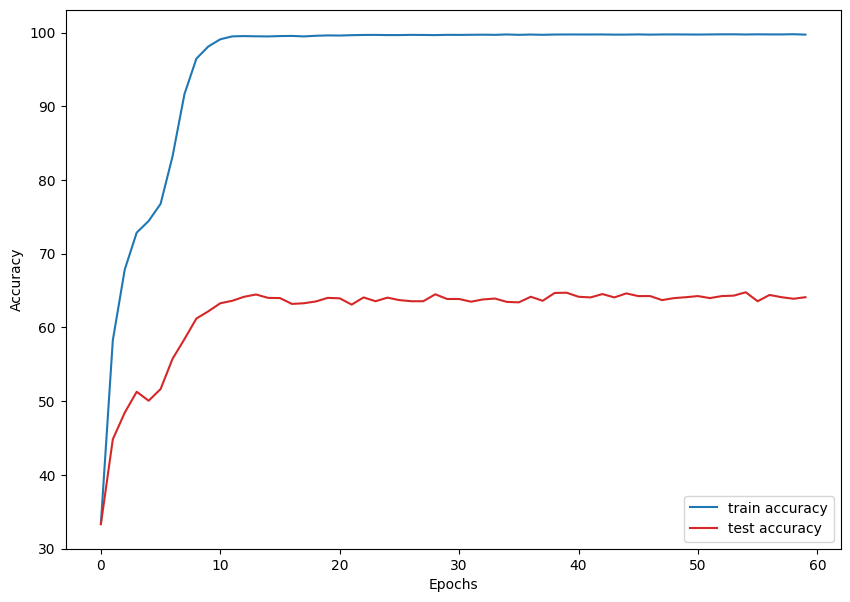

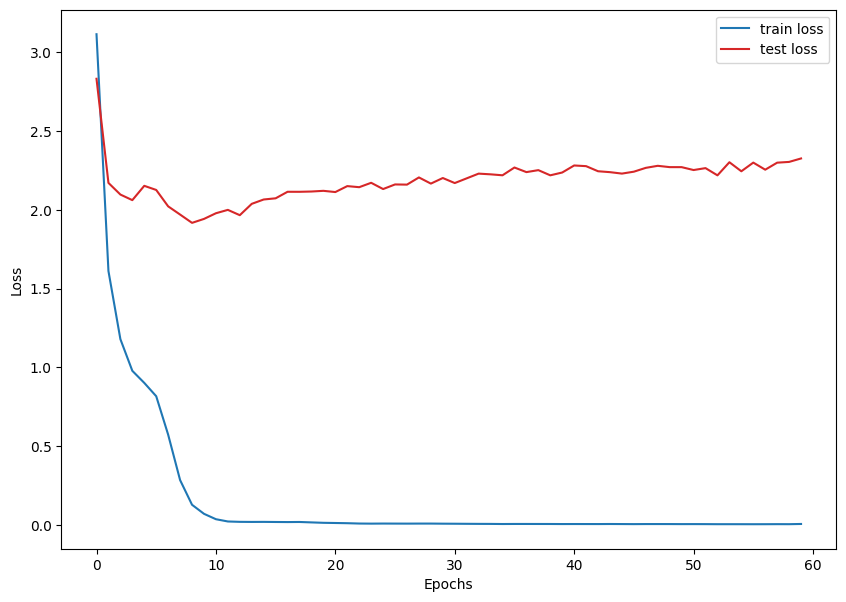

In [117]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model_ft, 
        train_dataloader, 
        optimizer,
        scheduler,
        criterion,
        device
    )
    print(scheduler.get_last_lr())
    test_epoch_loss, test_epoch_acc = test(
        model_ft, 
        test_dataloader, 
        criterion,
        device
    )
    
    if test_epoch_acc > max_test_acc:
        max_test_acc = test_epoch_acc
        best_model = copy.deepcopy(model_ft)
    
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Test loss: {test_epoch_loss:.3f}, test acc: {test_epoch_acc:.3f}")
    print('-'*50)
        
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    test_acc, 
    train_loss, 
    test_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')

In [118]:
max_test_acc

64.77203647416412

# 7. Testing

In [1848]:
#best_model1 = copy.deepcopy(best_model)
# model_ft = copy.deepcopy(best_model)

In [25]:
import urllib.request
def download_photo(link, name):
    url = link
    filename = name
    urllib.request.urlretrieve(url, filename)
    temp_preprocessing = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            ])
    return temp_preprocessing(Image.open(name))

In [26]:
temp_link = "https://yt3.googleusercontent.com/loUcR8pZjnzfSPtxNZtGHqL6qAXkbsUgwhnnfY_jVkY7b6rivLr0tvFq9_wJT3L84uTDcvt62Q=s176-c-k-c0x00ffffff-no-rj"
temp_img = download_photo(temp_link, "lenin.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


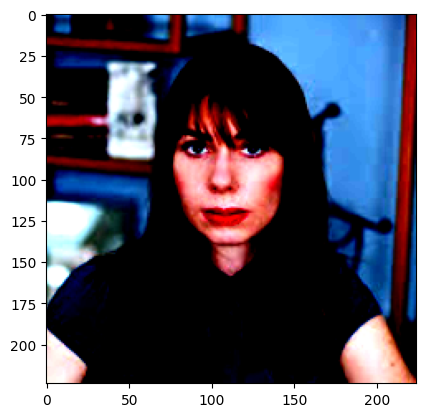

In [1785]:
plt.imshow(temp_img.squeeze().permute(1,2,0))
plt.show()

In [28]:
torch.topk(best_model(temp_img[None,:].to(device)).flatten(), 5).indices

tensor([142, 115, 178, 186, 192], device='cuda:0')

In [1787]:
labels_dict[177]

'Lepista'

In [198]:
best_model(img[None,:].to(device))[0].shape

torch.Size([1, 329])

In [62]:
err = []
for key in range(len(test_dataset)):
    img, label, _ = test_dataset[key]
    if label not in torch.topk(best_model(img[None,:].to(device))[0].flatten(), 5).indices:
        err.append(key)

In [63]:
(1 - len(err)/len(test_dataset))*100

86.50455927051672

In [31]:
err[0]

15

tensor([234, 188, 203, 201, 163], device='cuda:0') 234


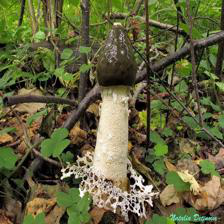

In [146]:
temp = test_dataset[2342]
print(torch.topk(model_ft(temp[0][None,:].to(device))[0].flatten(), 5).indices, temp[1])
Image.open(temp[2])

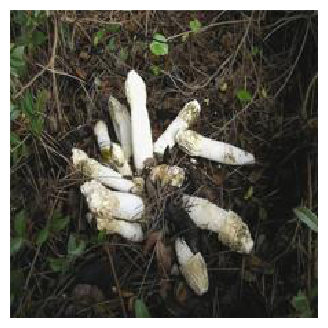

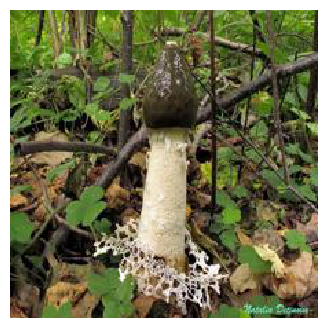

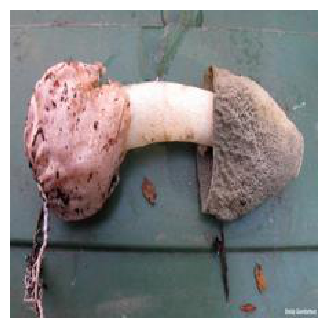

In [148]:
photo = shroom[labels_dict[temp[1]]]
size = len(temp)
for _ in range(3):  
    j = random.randint(0,size)
    image = mpimg.imread(photo[j])
    plt.axis('off')
    plt.imshow(image)
    plt.show()

# 8. Best acc

In [ ]:
for baselr in [1e-4, 2e-4, 3e-4]:
    for maxlr in [6e-4, 7e-4, 8e-4]:
        for wd in [1e-2, 1e-3, 1e-4]:

            model_ft = models.resnet18(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = torch.nn.Linear(num_ftrs, 332)
            model_ft.to(device);

            # Optimizer.
            optimizer = optim.AdamW(model_ft.parameters(), lr=learning_rate, amsgrad="True", weight_decay=wd)#optim.Adam(model_ft.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=baselr, max_lr=maxlr, cycle_momentum=False, mode="triangular2", step_size_up=3000)

            # Loss function.
            criterion = nn.CrossEntropyLoss()
            train_loss, test_loss = [], []
            train_acc, test_acc = [], []

            # Start the training.
            for epoch in range(epochs):
                print(f"[INFO]: Epoch {epoch+1} of {epochs}")
                train_epoch_loss, train_epoch_acc = train(
                    model_ft, 
                    train_dataloader, 
                    optimizer,
                    scheduler,
                    criterion,
                    device
                )
                print(scheduler.get_last_lr())
                test_epoch_loss, test_epoch_acc = test(
                    model_ft, 
                    test_dataloader, 
                    criterion,
                    device
                )

                if test_epoch_acc > max_test_acc:
                    max_test_acc = test_epoch_acc
                    best_model = copy.deepcopy(model_ft)
                    inf = (baselr, maxlr, wd)
                    print(max_test_acc, inf)
            print('TRAINING COMPLETE')

In [1775]:
inf

(0.0001, 0.0006, 0.001)

# 9. Confusion matrix and Error analysis  

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = []
y_true = []

# iterate over test data
for inputs, labels, _ in test_dataloader:
        output, _ = best_model(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

[0,
 216,
 0,
 0,
 0,
 0,
 0,
 142,
 0,
 0,
 76,
 1,
 1,
 1,
 243,
 1,
 265,
 1,
 1,
 1,
 249,
 2,
 2,
 146,
 225,
 76,
 2,
 2,
 2,
 2,
 3,
 186,
 3,
 66,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 277,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 62,
 5,
 5,
 6,
 6,
 6,
 6,
 132,
 6,
 6,
 6,
 6,
 6,
 66,
 7,
 7,
 66,
 66,
 7,
 6,
 66,
 7,
 7,
 8,
 8,
 118,
 8,
 328,
 8,
 237,
 328,
 237,
 8,
 51,
 9,
 9,
 9,
 228,
 9,
 51,
 9,
 9,
 103,
 10,
 76,
 8,
 10,
 149,
 76,
 162,
 10,
 10,
 162,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 3,
 77,
 11,
 265,
 265,
 12,
 265,
 265,
 62,
 265,
 12,
 62,
 12,
 13,
 267,
 262,
 13,
 13,
 13,
 13,
 13,
 312,
 13,
 14,
 18,
 14,
 14,
 14,
 14,
 14,
 103,
 14,
 14,
 15,
 316,
 15,
 15,
 244,
 199,
 15,
 15,
 15,
 13,
 304,
 247,
 16,
 247,
 247,
 3,
 235,
 16,
 244,
 16,
 17,
 17,
 309,
 83,
 36,
 17,
 17,
 156,
 17,
 115,
 18,
 280,
 18,
 18,
 233,
 18,
 18,
 84,
 18,
 103,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 19,
 19,
 19,
 204,
 293,
 326,
 20,
 293,
 20

In [167]:
err = []
for key in range(len(test_dataset)):
    img, label, _ = test_dataset[key]
    if label not in torch.topk(best_model(img[None,:].to(device))[0].flatten(), 50).indices:
        err.append(key)
len(err)

54

In [172]:
len(err)

54

In [72]:
torch.topk(best_model(test_dataset[12][0][None,:].to(device))[0], 5)

torch.return_types.topk(
values=tensor([[14.4908,  1.4655,  1.3037,  0.7670,  0.7507]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[  1,  60, 177, 146,   3]], device='cuda:0'))

In [170]:
err_array = []
for i in range(len(err)):
    temp_img, temp_label = torch.max(best_model(test_dataset[err[i]][0][None,:].to(device))[0], 1)
    err_array.append(temp_img.tolist() + [temp_label, test_dataset[err[i]][2]])

In [218]:
err_array.sort(key=lambda err: err[0], reverse=True)

mushrooms/Fomitopsis pinicola/000001.jpg


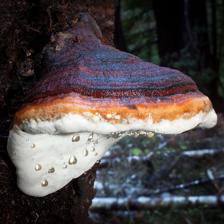

In [219]:
temp = 'mushrooms/Fomitopsis pinicola/000001.jpg'
print(temp)
Image.open(temp)

mushrooms/Trichaptum abietinum/000035.jpg


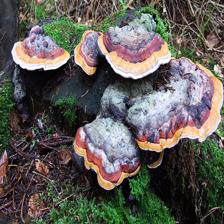

In [224]:
img = err_array[0]
print(img[2])
temp = int(img[1])
Image.open(img[2])

mushrooms/Fomitopsis pinicola/000003.jpg


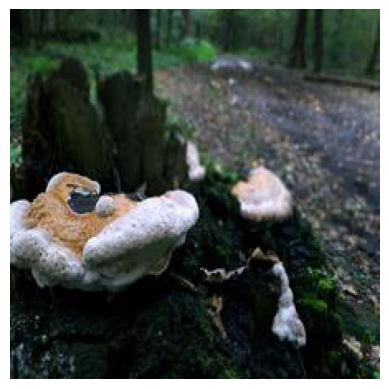

mushrooms/Fomitopsis pinicola/000023.jpg


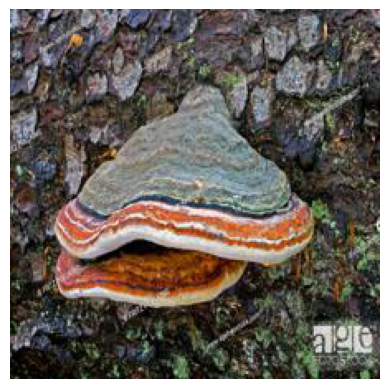

mushrooms/Fomitopsis pinicola/000019.jpg


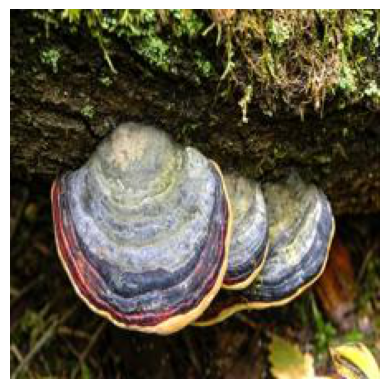

mushrooms/Fomitopsis pinicola/000010.jpg


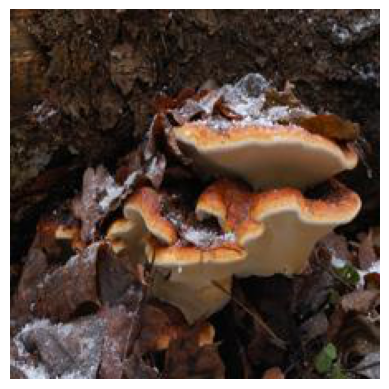

mushrooms/Fomitopsis pinicola/000005.jpg


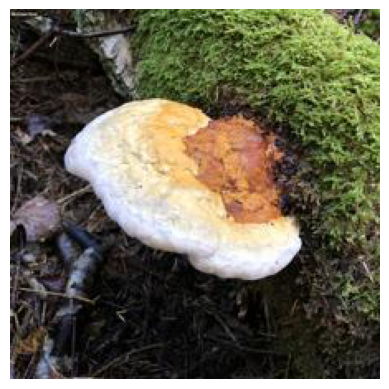

In [226]:
size = len(shroom[labels_dict[temp]])
for _ in range(5):  
    j = random.randint(0,size)
    print(shroom[labels_dict[temp]][j])
    image = mpimg.imread(shroom[labels_dict[temp]][j])
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [45]:
temp = 0
for key in temp_dict:
    temp = 0
    for i in err_array:
        if key in i[2]:
            temp += 1
            temp_dict[key] = temp
temp_dict

{'Agaricus': 3,
 'Amanita': 1,
 'Clitocybe': 5,
 'Cortinarius': 0,
 'Entoloma': 6,
 'Hygrophorus': 4,
 'Lactarius': 0,
 'Mycena': 7,
 'Pholiota': 1,
 'Pluteus': 2,
 'Russula': 3,
 'Suillus': 1,
 'Tricholoma': 4}

In [44]:
temp_dict = {
"Agaricus" : 0,
"Amanita" : 0,
"Clitocybe" : 0,
"Cortinarius" : 0,
"Entoloma" : 0,
"Hygrophorus" : 0,
"Lactarius" : 0,
"Mycena" : 0,
"Pholiota" : 0,
"Pluteus" : 0,
"Russula" : 0,
"Suillus" : 0,
"Tricholoma" : 0,
}

# 10 Balancing Dataset

In [36]:
class_weights = []
for key in shroom:
    class_weights.append(1/len(shroom[key]))

In [47]:
# Second method
class_weights = []
for key in shroom:
    class_weights.append(round(2121/len(shroom[key]), 0))

In [147]:
# Third method
class_weights = []
for key in shroom:
    temp = len(shroom[key])
    if temp < 100:
        class_weights.append(20.) #103/temp * 7
    elif temp > 500:
        class_weights.append(103/temp * 7) 
    else:
        class_weights.append(103/temp * 16) #103/temp * 3

In [148]:
sample_weights = [0] * len(train_dataset)
len(sample_weights), len(train_dataset)

(33892, 33892)

In [149]:
for key in train_dict:
    class_weight = class_weights[train_dict[key][1]]
    sample_weights[key] = class_weight

In [150]:
from torch.utils.data import WeightedRandomSampler 
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True) 

In [ ]:
class_weights

# 11. Cluster

In [ ]:
import pickle

In [200]:
with open('embeddings.pkl', 'wb') as f:
    for key in range(len(test_dataset)):
        img, label, _ = test_dataset[key]
        emb = best_model(img[None,:].to(device))[1].flatten()
        pickle.dump(emb, f)

In [46]:
temp = []
with open('embeddings.pkl', 'rb') as f:
    file = pickle.load(f) 
    while file[0]:
        temp.append(file)
        file = pickle.load(f)

EOFError: Ran out of input

In [47]:
X = np.array([i.cpu().detach().numpy() for i in temp])

In [336]:
len(X)

3290

In [48]:
labels = np.zeros(3290, dtype=np.int64)
for key in range(len(test_dataset)):
    labels[key] = test_dataset[key][1]

In [50]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

reduced_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X) #PCA(n_components=2).fit_transform(X_sorted)

In [470]:
# kmeans = KMeans(init="k-means++", n_clusters=120, n_init=4)
# cluster_labels = kmeans.fit_predict(reduced_data)

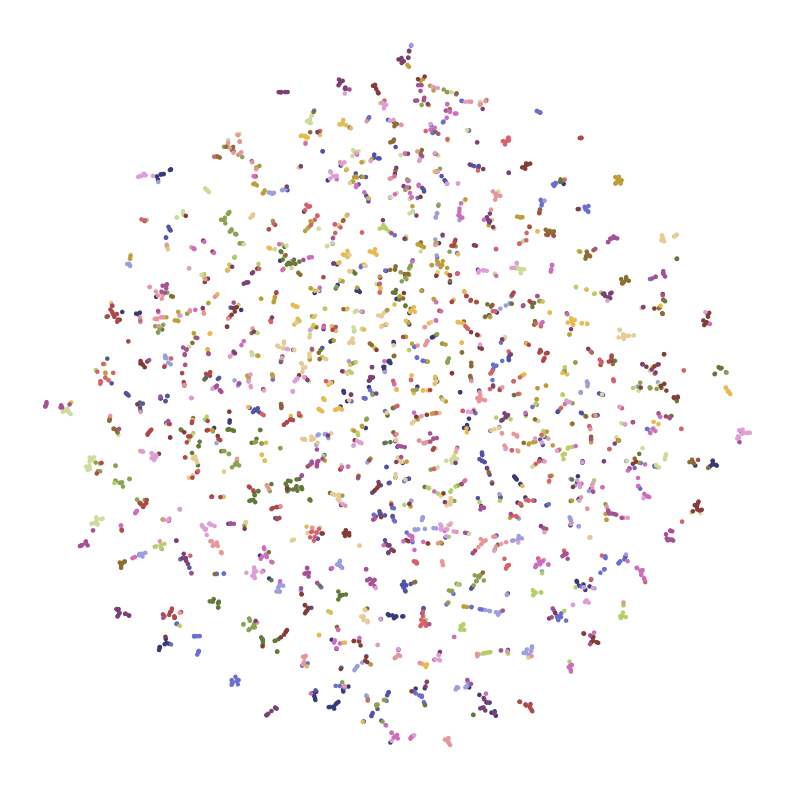

In [55]:
plt.figure(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab20b' ,s=5)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.axis("off")
plt.show()

In [403]:
labels_dict_reverse = {labels_dict[key]: key for key in labels_dict}

In [467]:
size = []
for i  in shroom.keys():
    if len(shroom[i]) > 550:
        print(str(labels_dict_reverse[i]) +': ' + str(len(shroom[i])))
        size.append(labels_dict_reverse[i])
len(size)

1: 811
6: 1086
76: 2121
146: 586
162: 1668
204: 672
244: 714
274: 1279
296: 642
309: 1110


10

In [52]:
X_sorted = np.zeros((len(size)*10, 1280), dtype= np.float64)
Y_sorted = np.zeros(len(size)*10, dtype= np.int64)
t = 0
for i in range(len(labels)):
    if labels[i] in size:
        X_sorted[t] = X[i]
        Y_sorted[t] = labels[i]
        t += 1
X_sorted[-1]

NameError: name 'size' is not defined

In [17]:
import pickle
filename = 'model.pkl'
with open(filename, 'rb') as file:
     best_model = pickle.load(file)


In [18]:
best_model.to(device);

In [21]:
filename = 'test_dataset.pkl'
with open(filename, 'rb') as file:
     test_dataset = pickle.load(file)

In [176]:
embeddings, predict = best_model(test_dataset[0][0][None,:].to(device))

In [187]:
import torch
import torch.nn.functional as F

# Calculate similarity matrix
similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(0))


TypeError: cosine_similarity() missing 1 required positional arguments: "x2"

In [178]:
normalized_similarity_matrix = (similarity_matrix - similarity_matrix.min()) / (similarity_matrix.max() - similarity_matrix.min())

(-0.5, 0.5, 0.5, -0.5)

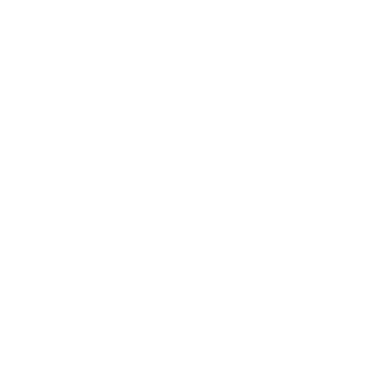

In [ ]:
import matplotlib.pyplot as plt

# Plot the heatmap
plt.imshow(normalized_similarity_matrix.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.axis("off")

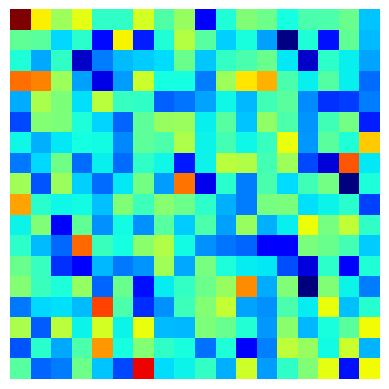

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# a = embeddings.cpu().detach().numpy()
plt.imshow(a, cmap='jet', interpolation='nearest')
plt.axis("off")
plt.show()

In [213]:
a = embeddings.cpu().detach().numpy()[0][:324].reshape(18,18)

In [214]:
print(a)

[[  5.4581757   -5.147434    -8.665963    -5.9807873  -12.664213
  -12.741454    -6.5719876  -11.5244665   -8.87976    -21.655565
  -13.314831    -9.734296   -10.448953   -13.673012   -11.783132
  -11.646101   -10.608367   -15.538422  ]
 [-10.9429655  -11.172065   -14.853462   -12.932401   -21.176664
   -5.246805   -20.560091   -13.306954    -7.793412   -11.339789
  -15.114332   -13.516066   -16.58735    -25.10344    -13.273426
  -20.871765   -10.914851   -15.676605  ]
 [-13.296003   -16.307768   -12.6895275  -23.231268   -17.58547
  -15.740864   -15.299397   -14.723451   -10.5202     -15.310544
  -12.6144285  -11.813685   -10.522419   -14.425732   -23.293522
  -12.812259   -14.196991   -16.42091   ]
 [ -0.9100702   -1.6110605   -8.629933   -16.54208    -22.4769
  -16.712023    -7.002941   -13.706943   -13.715217   -17.586002
   -8.585263    -4.81042     -3.120821   -11.818732   -14.123452
  -11.393095   -14.174601   -18.066633  ]
 [-16.223923    -8.127597    -9.832013   -14.671809    